Two stars are created, with known spectral energy density. The specifics of the numbers don't matter, only that there are two distinct densities.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.integrate as spi
import scipy.optimize as spo
import scipy.misc as spm
import scipy.special as sps
# from sklearn import linear_model

class STAR:
    def __init__(self, temp, count=5e5):
        self.temp = temp
        self.makeSED()
        # Represents the total number of counts at all wavelengths, to get around converting integrated sed to
        # counts, to not define telescope size, angular size etc
        self.totCount = count
    def makeSED(self):
        h = 6.62607e-34
        c = 2.99792e8
        k = 1.380649e-23
        self.SED = lambda l: (2*h*c**2)/(l**5)*(1/(np.exp((h*c)/(l*k*self.temp))-1))
        # Total flux of a black body at temp T
        self.norm = 2*np.pi**4*k**4*self.temp**4/(15*h**3*c**2)
    def countsFromBand(self, low, hi):
        return spi.quad(self.SED,low,hi)[0]/self.norm*self.totCount
    def bandTimesCount(self, low, hi, flux):
        return spi.quad(self.SED,low,hi)[0]/self.norm*flux

star1 = STAR(4000)
star2 = STAR(4300,4e5)

Next a sythetic one dimensional image is created. A gaussian is used for the point spread function. We assume a square wave filter with transmission from 736nm to 876nm.

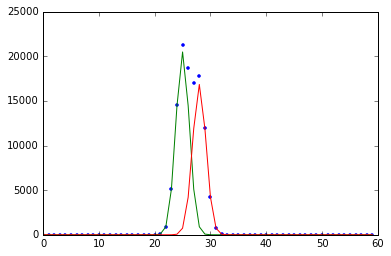

In [2]:
pixels = 60.
axis = np.arange(pixels) # Coordinates for image with 50 pixels
filt = (736e-9,876e-9)

psf = lambda x, mu, sigma: 1/(sigma*np.sqrt(2*np.pi))*np.exp(-1*(x-mu)**2/(2*sigma**2))

star1Dist = psf(axis, 25, 1.2)
star1Dist /= star1Dist.sum()
star1Dist *= star1.countsFromBand(*filt)

star2Dist = psf(axis, 28, 1.2)
star2Dist /= star2Dist.sum()
star2Dist *= star2.countsFromBand(*filt)

image0 = star1Dist+star2Dist
plt.plot(image0,'.')
plt.plot(star1Dist,'-')
plt.plot(star2Dist,'-')
plt.show()


The above plot shows how two stars with the same bightness which are located near each other in detector coordinates (a crowded field) can combine together to give the aperance of a single star. However the bightness of each pixel is a function of the sum of the SED of the stars, and hense each pixel will be just a bit different due to the differing linear combinations. This image is a theroretical image at airmass 0, and thus has not undergone any differential cromatic aberation. Stated another way, each wavelength is only distributed according to the point spread function.

Now we implement a simple dcr spreading function. This is a function of wavelength and airmass. The exact form of the dispersing function is a simple cartoon model, but mimics the behaviro of a real dispersion function. We then create four images at different airmasses that are a result of this dispersion function. To these images we add white noise.

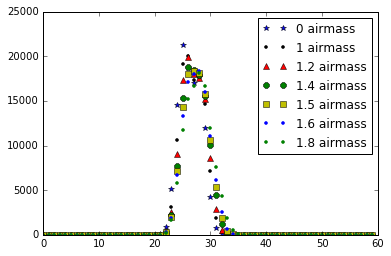

(112262.99186973332, 112262.99186973332, 112262.99186973333, 112262.99186973332)


In [3]:
# Create a DCR function, specifying the amount various wavelengths will be moved in pixel coordinates
# and fitting a polynomial to enable calculating any wavelength
waverange = [736,801,876]
distance = [0,0.28,1.2]
#distance = [0,1.5,5.6]
dcrFunc = np.poly1d(np.polyfit(waverange,distance,2))
# Add a simple airmass dependance, scaling the displacement
#dcrFuncz = lambda l,z: z**1.5*dcrFunc(l)
#dcrFuncz = lambda l,z: z*dcrFunc(l)
dcrFuncz = lambda l,z: z**2.2*dcrFunc(l)

# A list of the airmasses images will be created at
airmass = [1,1.2,1.4,1.5,1.6,1.8]

def makeImage(size,std,airmass,wavelow,wavehigh,indep,star1pos=25,star2pos=28,star1width=3.0,star2width=3.3):
    image = np.zeros(size)
    trueSED = np.zeros((size,wavehigh-wavelow))

    # loop over each wavelength (quantized)
    for i in np.arange(wavelow,wavehigh):
        # calculate the dcr offset for this wavelength
        distance = dcrFuncz(i,airmass)
    
        # Create the stelar image at each wavelength
        star1Disttemp = psf(indep, star1pos+distance, star1width)
        star1Disttemp /= star1Disttemp.sum()
        star1Disttemp *= star1.countsFromBand(i*1e-9,(i+1)*1e-9)
    
        star2Disttemp = psf(indep, star2pos+distance, star2width)
        star2Disttemp /= star2Disttemp.sum()
        star2Disttemp *= star2.countsFromBand(i*1e-9,(i+1)*1e-9)
    
        stepSED = (star1Disttemp + star2Disttemp)
        trueSED[:,i-736] = stepSED
        image += stepSED
        imageNoise = image + np.random.normal(0,std,len(image))
    return image,imageNoise,trueSED

imageSigma = 700

testImage,testImageNoise,testSED = makeImage(len(image0),400,airmass[0],736,876,axis)
image1,image1Noise = makeImage(len(image0),imageSigma,airmass[0],736,876,axis,star1width=1.2,star2width=1.2)[:2]
image2,image2Noise = makeImage(len(image0),imageSigma,airmass[1],736,876,axis,star1width=1.2,star2width=1.2)[:2]
image3,image3Noise = makeImage(len(image0),imageSigma,airmass[2],736,876,axis,star1width=1.2,star2width=1.2)[:2]
image4,image4Noise = makeImage(len(image0),imageSigma,airmass[3],736,876,axis,star1width=1.2,star2width=1.2)[:2]
image5,image5Noise = makeImage(len(image0),imageSigma,airmass[4],736,876,axis,star1width=1.2,star2width=1.2)[:2]
image6,image6Noise = makeImage(len(image0),imageSigma,airmass[5],736,876,axis,star1width=1.2,star2width=1.2)[:2]

# Plot the images with no noise to make the plot easier to interpret

plt.plot(image0,'b*', label="0 airmass")
plt.plot(image1,'k.', label='1 airmass')
plt.plot(image2,'r^', label='1.2 airmass')
plt.plot(image3,'g8', label='1.4 airmass')
plt.plot(image4,'ys', label='1.5 airmass')
plt.plot(image5,'.',label='1.6 airmass')
plt.plot(image6,'.',label='1.8 airmass')
plt.legend(loc=0)
plt.show()

# Print to verify that the total flux remains the same
print(np.sum(image1), np.sum(image2), np.sum(image3), np.sum(image4))

Now that we have synthetic images, we must attempt to create some mapping that will inference from one image to another. 

Begin by considering that each pixel in the above image has it's own effective SED. Secondly concider that baring things like noise and transparency issues, there will be a conservation of flux (except when it runs off the fram) from image to image. That is DCR will move the flux around, but will not remove it. We can then visualize the flux of each component wavelength for the SED within an individual pixel as simply being transfered from one pixel to another. Therefore each image is just an individual realization of an image at zero airmass being mapped though a transfer function. Practically this means that the value within pixel X will the the sum of the wavelengths within pixel X that have not been moved out of the pixel, and waveleths from some pixel Y which have been moved into pixel X. Thus, the problem can be written as some transfer matrix times a vector of each component of each SED for every pixel.

Practically the transfer matrix can be implimented as matrix with columns corresponding to the all of the components in each SED of every pixel, and rows which correspond to a particular pixel on the detector. So each pixel (a row in the transfer matrix) will be a vector with weights at locations which correspond to wavelengths which will be found in the pixel at the airmass being investigated. In other words, if pixel 20 is expected to only have wavelength lambda1 from pixel 19 (labda_1_19) and lambda2 from pixel20 (labda_2_20) the row in the transfer matrix will have ones in these lambda locations, and zeros everwhere else.

Because we know how the dcr function will move flux around, we can construct such vectors. For practical implementation, we choose a small number of "bandpasses" which will represent the whole wavelength range of our image. I.E. divide the range of 736 to 876 nanometers into 20 bands. We visualize these twenty numbers for each pixel to be stacked in a single column vector. We can then arange the binary transfer matrix such that for each row by column multiplication in the linear algebra equation will result in the sum of the wavelengths from each pixel which are expected to contribute to the corresponding pixel in the real image. This gives a matrix equation in the form Ax=b where b is the image at a particular airmass, and A is the transfer matrix which corresponds to that airmass.

At this point It would seem that there is a great number of degeneracies in in this matrix equation. To help mitigate this, we make use of the fintie difference matricies which ensure a certain smoothness to the data. That is to say we expect the value of each pixel to be some smooth function and not a complex arangement of random values. Secondly we can "stack" the transfer matrices for multiple airmasses, as well as "stacking" multiple images. However, since each of the stacked images is created with the same input SEDs, no additional parameters are introduced. These two effects seem to effectively constrain the minimization process as shown below.

In [4]:
# Create a range of lambdas to consider when guessing the sed
noLambdaPts = 20
waveBands = np.linspace(736,876,noLambdaPts)    
    
def buildTransfer(z,numLambda,low,high,imageLength):
    waveBands = np.linspace(low,high,numLambda)

    # Calculate how far these wavelengths will move from zero airmass to airmass at image 1
    distImage = abs(dcrFuncz(waveBands,z))
    
    # For now, round to the nearest pixel, as there is no information below the bands chosen at this point
    # It may be posible to do a more detailed approach in the future
    #distImage = np.array(np.round(abs(distImage)), dtype=int)
    #distImage = np.array(abs(distImage), dtype=int)

    # Begin constructing transfer matrix, should be x dimension of no of pixels times noLambdaPts, and a 
    # y dimension of the number pixels

    transferMatrix = np.zeros((imageLength,imageLength*numLambda))

    # Build a temp matrix that will be how the flux contributions will fall
    # the + 1 is because we want to go one more than the end
    # celing the max value to take up to the next integer
    subTransfer = np.zeros((int(np.ceil(distImage.max()))+1,noLambdaPts))

    for i in range(subTransfer.shape[0]):
        temp = []
        for j in range(len(distImage)):
            if distImage[j] >= i-1 and distImage[j] < i:
                temp.append(distImage[j]-(i-1))
            elif distImage[j] >= i and distImage[j] < i + 1:
                temp.append(1 - (distImage[j] - i))
            else:
                temp.append(0)
        #subTransfer[i,:] = np.array(np.round(distImage) == i, dtype=int)
        subTransfer[i,:] = temp[:]
    # Populate transfer matrix, loop over the number of pixels in the image
    sdisy = subTransfer.shape[0]
    sdisx = numLambda
    for i in range(imageLength):
        if imageLength - i < sdisy:
            sdisy = imageLength - i
        transferMatrix[i:i+sdisy,i*sdisx:i*sdisx+sdisx] = subTransfer[:sdisy,:]
    return transferMatrix

transferMatrix1 = buildTransfer(airmass[0],noLambdaPts,736,876,len(image0))
transferMatrix2 = buildTransfer(airmass[1],noLambdaPts,736,876,len(image0))
transferMatrix3 = buildTransfer(airmass[2],noLambdaPts,736,876,len(image0))
transferMatrix4 = buildTransfer(airmass[3],noLambdaPts,736,876,len(image0))
transferMatrix5 = buildTransfer(airmass[4],noLambdaPts,736,876,len(image0))
transferMatrix6 = buildTransfer(airmass[5],noLambdaPts,736,876,len(image0))

Below we create the matrices which regularize the set of equations. We use the first and second finte difference matrices to ensure pixel to pixel smoothness, and also a first order finte difference matrix to ensure that the SED within on pixel is a smooth function. We fit only three images and show how we can predict the other three. The fitting itself is done by taking the derivative of the log likely function, and setting it equal to zero, and directly solving for which paramters maxize the likelyhood.

In [5]:
from scipy.linalg import toeplitz

def difference(size):
 """ returns a toeplitz matrix
   difference regularization
 """
 r = np.zeros(size)
 c = np.zeros(size)
 r[0] = 1
 r[size-1] = -1
 c[1] = -1
 return toeplitz(r,c).T

def difference2(size):
    r = np.zeros(size)
    r[0] = 2
    r[1] = -1
    r[-1] = -1
    matrix = np.zeros((size,size))
    for i in range(size):
        matrix[i] = np.roll(r,i)
    return matrix



# Calculate a difference matrix for regularization as if each wavelength were a pixel, then scale
# The difference matrix to the size of the number of pixels times number of wavelengths
baseReg = difference(len(image6Noise))
Regular = np.zeros((noLambdaPts*len(image1Noise), noLambdaPts*len(image1Noise)))

for i in range(noLambdaPts):
    Regular[i::noLambdaPts,i::noLambdaPts] = baseReg

# Do the same thing as above but with the second derivative
baseReg2 = difference2(len(image6Noise))
Regular2 = np.zeros((noLambdaPts*len(image1Noise), noLambdaPts*len(image1Noise)))

for i in range(noLambdaPts):
    Regular2[i::noLambdaPts,i::noLambdaPts] = baseReg2
    
# Extra regularization that we force the SED to be smooth
baseLam = difference(noLambdaPts)
smthLam = np.zeros(Regular.shape)

for i in range(len(image0)):
    smthLam[i*noLambdaPts:i*noLambdaPts+noLambdaPts,i*noLambdaPts:i*noLambdaPts+noLambdaPts] = \
            baseLam

# Perform the minimization to find the most likely value of wavelengths of the form ||Ax-b||_2 + ||Rx||_2
# were xHat is the predicted values of the lambda vector
aMatrix = np.matrix(np.append(np.append(transferMatrix1, transferMatrix6,axis=0),transferMatrix3,axis=0))
bvec    = np.matrix(np.append(np.append(image1Noise, image6Noise), image3Noise))
xHat = np.dot(np.dot(np.linalg.pinv(np.dot(aMatrix.T, aMatrix) + 0.1*np.dot(Regular.T,Regular) + 0.1*np.dot(Regular2.T,Regular2) + 0.1*np.dot(smthLam.T,smthLam)), aMatrix.T), bvec.T)


Below we use the transfer matricies we calculated for the airmass corresponding with each paticular image to shift our best fit model parameters to produce a model image for each of the real images not used in the fit. We overplot the image with the model, the image minus the model, and the image minus image 1 (as if we used image 1 as the reference image in difference imaging)

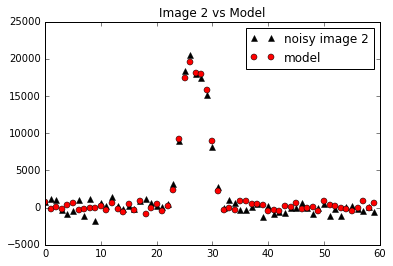

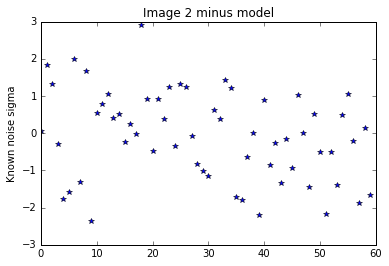

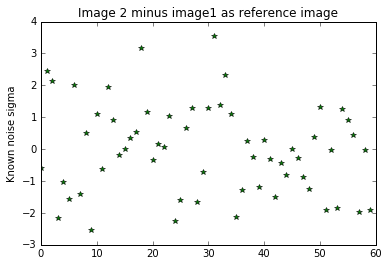

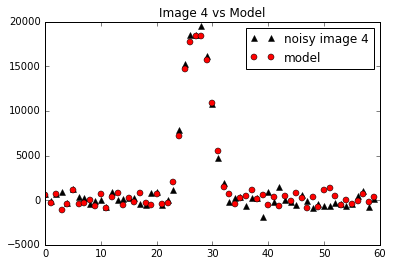

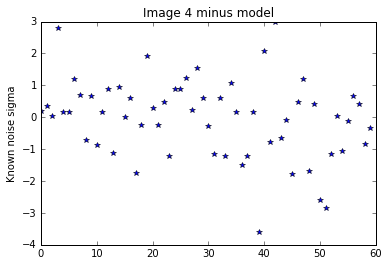

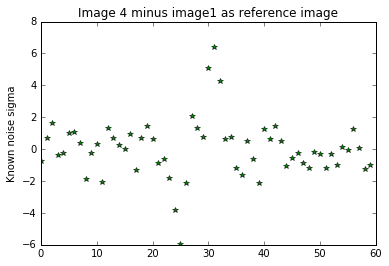

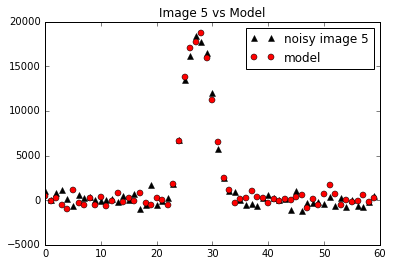

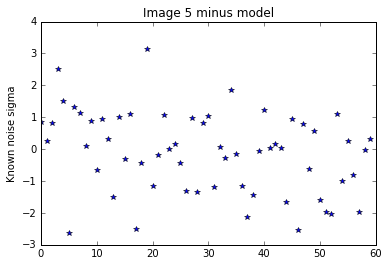

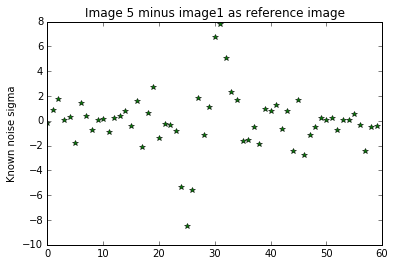

In [6]:
# For each airmass plot the Noisy image overlayed with the predicted model, the difference between the Noisy image
# and the model, and the difference had we used the noisy image1 as the template

imageVector = [image2Noise, image4Noise, image5Noise]
imageNo = [2,4,5]
transferVector = [transferMatrix2, transferMatrix4, transferMatrix5]

for i in range(len(imageVector)):
    plt.plot(imageVector[i],'k^', label='noisy image {}'.format(imageNo[i]))
    plt.plot(np.dot(transferVector[i],xHat),'ro', label="model")
    plt.title('Image {} vs Model'.format(imageNo[i]))
    plt.legend()
    plt.show()
    
    plt.plot((imageVector[i] - np.ravel(np.dot(transferVector[i],xHat)))/imageSigma,'b*')
    plt.title("Image {} minus model".format(imageNo[i]))
    plt.ylabel('Known noise sigma')
    plt.show()
    
    plt.plot((imageVector[i] - image1Noise)/imageSigma, 'g*')
    plt.title("Image {} minus image1 as reference image".format(imageNo[i]))
    plt.ylabel('Known noise sigma')
    plt.show()


From these plots we can see that the model represents the image quite well. When we compare the two difference images for image2 we see that the model compairs about as equally well as subtracting off image one, which is expected as they are very similar in airmass. There may be a slight dipole created in image two, but it would be hard to detect. When we look at the two other images however, we can see the evidence of a dipole in the difference image created with image 1 as the reference image, but no such issue in the difference image created with the model. These model differences largely fall within the range of the expected sigma of the image.

Below we repeat the above experiment, but ask the question what would happen if we used many many images (each with a different realization of the noise) to create a model, and then use that to difference images 2-6 (as image one is still used as a reference image). We can see the model improves quite a bit, especially in the background, and the standard deviation of the residuals approaches that of the noise of the image itself.

In [7]:
airmassArray = np.random.uniform(1,2,300)
imageList = []
transferList = []
for a in airmassArray:
    imageList.append(makeImage(len(image0),1000,a,736,876,axis,star1width=1.2,star2width=1.2)[1])
    transferList.append(buildTransfer(a,noLambdaPts,736,876,len(image0)))

aMatrix = np.append(transferList[0], transferList[1], axis=0)
bvec = np.append(imageList[0], imageList[1])
for i in range(2, len(transferList)):
    aMatrix = np.append(aMatrix, transferList[i], axis=0)
    bvec = np.append(bvec, imageList[i])

xHat = np.dot(np.dot(np.linalg.pinv(np.dot(aMatrix.T, aMatrix) + 0.1*np.dot(Regular.T,Regular) + 0.1*np.dot(Regular2.T,Regular2) + 0.1*np.dot(smthLam.T,smthLam)), aMatrix.T), bvec.T)


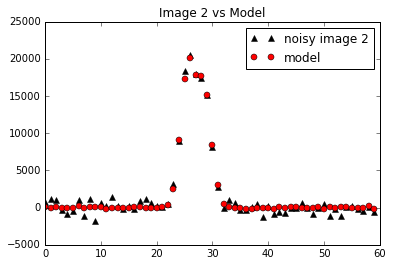

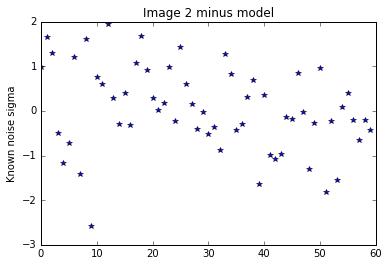

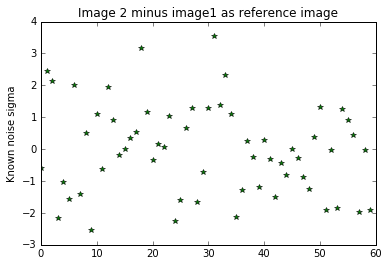

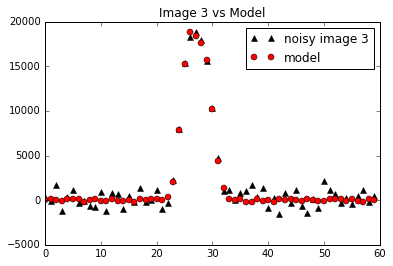

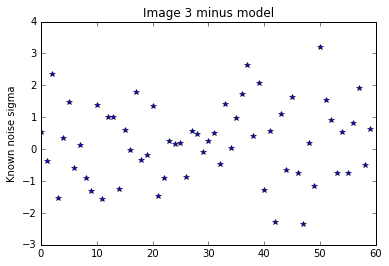

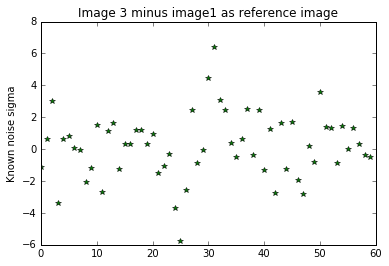

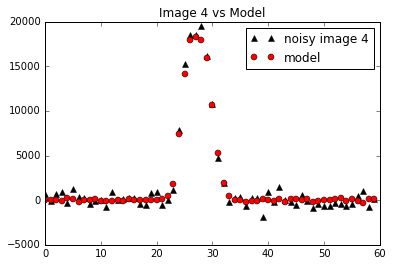

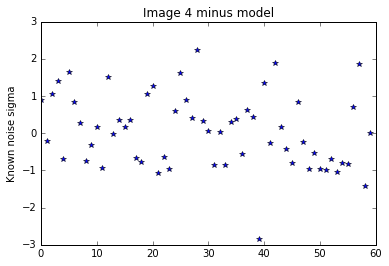

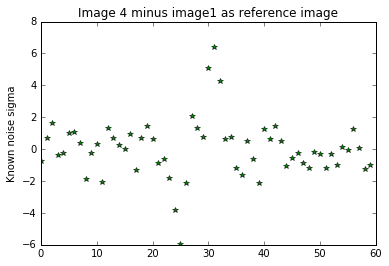

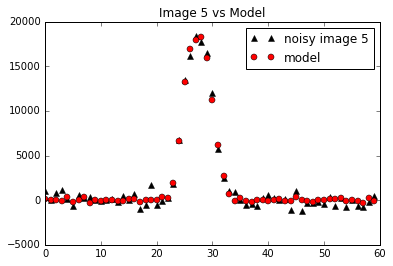

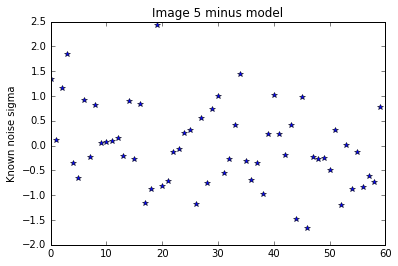

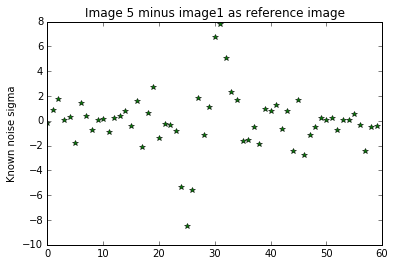

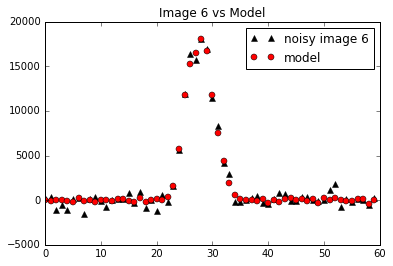

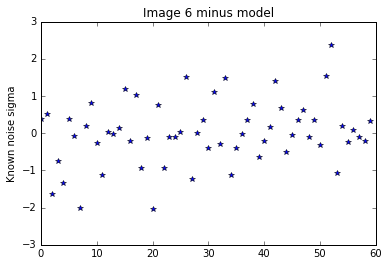

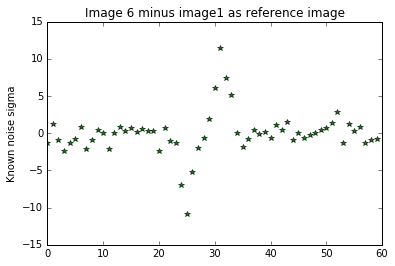

In [8]:
# For each airmass plot the Noisy image overlayed with the predicted model, the difference between the Noisy image
# and the model, and the difference had we used the noisy image2 as the template

imageVector = [image2Noise, image3Noise, image4Noise, image5Noise, image6Noise]
imageNo = [2,3,4,5,6]
transferVector = [transferMatrix2, transferMatrix3, transferMatrix4, transferMatrix5, transferMatrix6]

for i in range(len(imageVector)):
    plt.plot(imageVector[i],'k^', label='noisy image {}'.format(imageNo[i]))
    plt.plot(np.dot(transferVector[i],xHat),'ro', label="model")
    plt.title('Image {} vs Model'.format(imageNo[i]))
    plt.legend()
    plt.show()
    
    plt.plot((imageVector[i] - np.ravel(np.dot(transferVector[i],xHat)))/imageSigma,'b*')
    plt.title("Image {} minus model".format(imageNo[i]))
    plt.ylabel('Known noise sigma')
    plt.show()
    
    plt.plot((imageVector[i] - image1Noise)/imageSigma, 'g*')
    plt.title("Image {} minus image1 as reference image".format(imageNo[i]))
    plt.ylabel('Known noise sigma')
    plt.show()

Further experiments can be done in which the relative positions of the two stars can be varied to simulate seperate but near my stars, or lined up exactly to simulate one star (or just remove one source). The noise level on the images can be varied (imageSigma) to show the limit at which a star with a certain difference image detection does not rise above the background even with the dcr effect. Varying the signal to noise also shows at what level the function is able to model the dcr effect.

This whole discussion has ignored the discussion of the impact of a varying psf, which will eventually need to be taken into account. However the problem of DRC and the point spread function variability have been shown in the past to be a sperable problem, and it should be possible to fit a differential psf basis to each image (similar to how psf matching is done now) to account for that effect.